In [147]:
import sys
sys.path.append('/home/dnelson/project/msprime')
import msprime
import dask
import networkx as nx
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import os
from tqdm import tqdm
        

def digraph_kinship(G, samples, kinship, max_time=-1):
    ancestors = defaultdict(dict)
    climbers = {s: set([s]) for s in samples}
    
    i = 0
    while len(climbers) > 0:
        # Adding one only works if branch lengths are also == 1
        # TODO: Make more flexible ^^
        i += 1
        next_climbers = defaultdict(set)
        for sample, climbers in climbers.items():
            for climber in climbers:
                for anc in G.predecessors(climber):
                    next_climbers[sample].add(anc)
                    ancestors[anc][sample] = i

                    # Add kinship with other descendants who
                    # have reached this ancestor
                    for descendant in ancestors[anc]:
                        # print("Adding kinship between", sample, "and", descendant)
                        j = ancestors[anc][descendant]
                        idx = tuple(sorted([sample, descendant]))
                        kinship[idx] += 1 / (2 ** (i + j))
                    
        climbers = next_climbers
                    
    return kinship 


def tree_to_dict_of_dicts(tree):
    dod = {}
    for parent in tree.nodes():
        dod[parent] = {}
        for child in tree.children(parent):
            dod[parent][child] = {
                'branch_length': tree.branch_length(child)
            }
            
    return dod


class PedKinship:
    def __init__(self, G):
        self.G = G
        self.samples = None
        self.ancestor_dists = None
        self.kinship = None
        
    @staticmethod
    def from_array(pedarray):
        G = PedKinship.ped_to_digraph(pedarray)
        
        return PedKinship(G)   
        
    @staticmethod
    def from_txt(pedfile):
        pedarray = np.genfromtxt(
            os.path.expanduser(pedfile),
            skip_header=True,
            dtype=int)
                
        return PedKinship.from_array(pedarray)
        
    @staticmethod
    def ped_to_digraph(pedarray):
        G = nx.DiGraph()

        for child, father, mother in pedarray[:, :3]:
            if father > 0:
                G.add_edge(father, child)
            if mother > 0:
                G.add_edge(mother, child)

        return G
    
    def get_probands(self):
        return [v for v, d in self.G.out_degree() if d == 0]
    
    def _set_samples(self, samples):
        self.samples = samples
        n = len(samples)
        self.kinship = np.zeros((n, n))
    
    def _build_ancestor_dists(self, max_depth=7):
        if self.samples is None:
            raise ValueError("Samples not set")
            
        # Each ancestor has a dict holding a list of path lengths
        # keyed by child ID
        self.ancestor_dists = defaultdict(lambda: defaultdict(list))
        climbers = {x: set([s]) for x, s in enumerate(self.samples)}
        
        i = 0
        while len(climbers) > 0:
            if i > max_depth:
                break

            next_climbers = defaultdict(set)
            for sample_ix, climbers in climbers.items():
                for climber in climbers:
                    self.ancestor_dists[climber][sample_ix].append(i)
                    for anc in self.G.predecessors(climber):
                        next_climbers[sample_ix].add(anc)

            climbers = next_climbers
            # Adding one only works if branch lengths are also == 1
            # TODO: Make more flexible ^^
            i += 1
            
    def compute_kinship(self, samples, max_depth=7):
        self._set_samples(samples)
        self._build_ancestor_dists(max_depth=max_depth)
        
        for anc, dists in tqdm(self.ancestor_dists.items(), total=len(self.ancestor_dists), smoothing=0.1):
            children = list(self.G.successors(anc))
            children_dists = [self.ancestor_dists[c] for c in children if c in self.ancestor_dists]

            for paths1, paths2 in itertools.combinations(children_dists, 2):
                for sample_idx1, lengths1 in paths1.items():
                    for sample_idx2, lengths2 in paths2.items():
                        for l1, l2 in itertools.product(lengths1, lengths2):
                            self.kinship[sample_idx1, sample_idx2] += 1 / (2 ** (l1 + 1 + l2 + 1))

In [148]:
# pedfile = '/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt'
# PK = PedKinship.from_txt(pedfile)
# G = PK.G

In [149]:
PK = PedKinship(G)

probands = PK.get_probands()
# PK.set_samples(probands[:5000])
# PK.build_ancestor_dists(max_depth=5)

In [150]:
children = PK.compute_kinship(probands, max_depth=5)

100%|██████████| 145509/145509 [00:03<00:00, 41357.28it/s]


In [140]:
PK.kinship.max()

0.51611328125

In [146]:
np.where((PK.kinship < 0.5) & (PK.kinship > 0.4))[0].shape

(0,)

In [76]:
probands[38]

199325

In [77]:
probands[39]

199329

In [80]:
nx.lowest_common_ancestor(PK.G, 199325, 199329)

91256

In [82]:
list(PK.G.successors(91256))

[199325, 199329]

In [101]:
ts = msprime.simulate(10, mutation_rate=1e-8, length=1e8, Ne=10, model='dtwf')

print(ts.first().draw(format='ascii'))

     17            
  +---+----+       
  |       16       
  |     +--+--+    
  |     |    15    
  |     |   +-+--+ 
 13     |   |   14 
+-+-+   |   |   +++
|  12   |   |   | |
| +-++  |   |   | |
| | 11  |  10   | |
| | +++ | +-+-+ | |
6 2 4 9 3 0 1 7 5 8



In [102]:
samples = [7, 6]
kinship = init_sparse_kinship(samples)

for tree in ts.trees():
    g = nx.DiGraph(tree_to_dict_of_dicts(ts.first()))
    a = digraph_kinship(g, samples, kinship)

In [103]:
kinship.data

array([list([]), list([]), list([]), list([]), list([]), list([]),
       list([0.75, 0.125]), list([0.9375])], dtype=object)

In [47]:
a.nonzero()

(array([6, 6, 7], dtype=int32), array([6, 7, 7], dtype=int32))

In [103]:
list(g_ped.predecessors(79826))

[76060, 77127]

In [114]:
leaves = get_digraph_leaves(g_ped)

In [115]:
leaves[:2]

[79826, 99455]

In [119]:

list(nx.all_simple_paths(g_ped, 79826, 99455, cutoff=15))

[]

In [122]:
ts = msprime.load('/home/dnelson/project/pedigree_msp/results/Luke/chrom1_4134samples_Ne10000.h5')
pedfile = '/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt'
ped = np.genfromtxt('/home/dnelson/project/pedigree_msp/data/Luke/Genizon_4149gen_nov2019.txt',
                    skip_header=True, dtype=int)

In [5]:
g_ped = ped_to_digraph(ped)


np.histogram([d for v, d in g_ped.out_degree()], bins=range(10))

(array([  4134, 146021,  39059,  19652,  11718,   7535,   4499,   2896,
          2612]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [27]:
leaves = [v for v, d in g_ped.out_degree() if d == 0]

In [41]:
%timeit a = nx.ancestors(g_ped, 79826)

2.71 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
nx.draw(g, with_labels=True)

100%|██████████| 50/50 [00:00<00:00, 10667.64it/s]


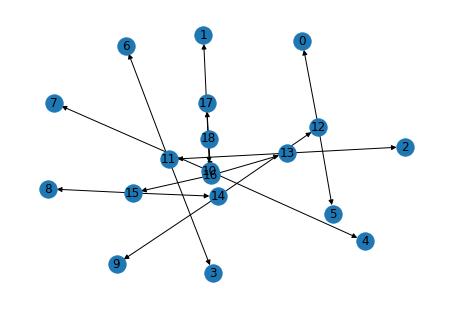

In [69]:
plt.show()

In [27]:
tree = ts.first()

# a dictionary of dictionaries to represent our distance matrix
dist_dod = collections.defaultdict(dict)
for source, target in itertools.combinations(tree.samples(), 2):
    dist_dod[source][target] = nx.shortest_path_length(
        g, source=source, target=target, weight="branch_length"
    )
    dist_dod[target][source] = dist_dod[source][target]

# extract the nearest neighbor of nodes 0, 1, and 2
nearest_neighbor_of = [min(dist_dod[u], key=dist_dod[u].get) for u in range(3)]

print(dict(zip(range(3), nearest_neighbor_of)))

{0: 7, 1: 6, 2: 0}


In [9]:
ts = msprime.simulate(10, mutation_rate=1e-8, length=1e8, Ne=10, model='dtwf')
g = nx.Graph(tree_to_dict_of_dicts(ts.first()))
print(ts.first().draw(format='ascii'))

     18            
  +---+---+        
  |      17        
  |    +--+-+      
  |    |   16      
  |    |  +-+--+   
 15    |  |    |   
+-++   |  |    |   
|  |  14  |    |   
|  |  +++ |    |   
|  |  | | |   13   
|  |  | | |  +-+-+ 
| 12  | | |  |  11 
| +++ | | |  |  +++
| | | | | | 10  | |
| | | | | | +++ | |
8 4 9 5 6 3 0 2 1 7



Taking the graph-based distance, weighted by branch lengths, how do we convert to kinship? $\frac{1}{2 ^{(d / 2)}}$?

In [40]:
for i, path in enumerate(nx.shortest_simple_paths(g_ped_undirected, leaves[0], leaves[1])):
    if len(path) > 12:
        print(i, path)
        break

28 [79826, 76060, 75400, 763677, 760738, 69797, 69790, 153935, 146753, 764950, 146750, 76133, 99455]


In [29]:
g_ped_undirected = nx.Graph(g_ped)

In [42]:
c = nx.communicability(g_ped_undirected)

MemoryError: Unable to allocate array with shape (238902, 238902) and data type float64

In [105]:
nx.lowest_common_ancestor(g_ped, leaves[0], leaves[1])

773180